## Загрузка библиотек

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import seaborn as sb

import time
sb.set()

## 1. Подготовка данных

#### Загрузим датасет и посмотрим на него

In [3]:
data = pd.read_csv('autos.csv')
data.sample(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7759,2016-03-08 17:47:27,6999,wagon,2004,auto,218,c_klasse,150000,5,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,96486,2016-03-11 00:44:24
95874,2016-04-04 14:56:15,500,bus,1998,manual,75,kangoo,150000,1,petrol,renault,no,2016-04-04 00:00:00,0,26817,2016-04-04 14:56:15
315389,2016-04-04 16:37:38,1950,sedan,2000,manual,177,other,150000,5,petrol,rover,no,2016-04-04 00:00:00,0,45357,2016-04-06 18:16:30


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

##### Есть пропуски, на них посмотрим позже

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


#### Удалим колонки которые явно не имеют смысла для предсказания цены:  
1. DateCrawled - дата получения объявления из базы
2. DateCreated - дата создания объявления
3. LastSeen - последняя активность пользователя
4. NumberOfPictures - количество фото, оно везде равно 0, поэтому признак не имеет никакого смысла
5. PostalCode - индекс почты владельца, скорее всего он не влияет на цену, хоть определяет местоположение владельца авто, т.к. цена по рынку в стране и даже в соседних странах практически идентична.

Видно, что в столбце RegistrationYear есть 1000 и 9999 год, посмотрим на количесвто таких выбросов.
Так что в столбце Power есть выбросы. Проверим всё это

In [6]:
drop_list = ['DateCrawled','DateCreated','LastSeen','NumberOfPictures','PostalCode']
data = data.drop(drop_list, axis=1)

In [7]:
data.sample(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
81647,700,small,2002,manual,75,agila,125000,10,petrol,opel,no
114176,950,small,1996,NaN,45,corsa,150000,7,petrol,opel,NaN
228213,2550,wagon,2003,manual,105,touran,150000,1,gasoline,volkswagen,no


#### Удалим строки с датой регистрации 
меньше 1950 и больше 2020 года (Авто из будущего нас не очень интересуют, как и старше 1950 года - они скорее всего остались в единичных экземлярах)

In [8]:
data = data.drop(data.query('RegistrationYear>2020 or RegistrationYear<1950').index.to_list())

In [9]:
data = data.drop(data.query('Power>500').index.to_list())

##### Посмотрим на пропуски в процентом соотношении

In [10]:
data.isna().sum().sort_values(ascending=False)/len(data)

NotRepaired          0.200052
VehicleType          0.105164
FuelType             0.092165
Gearbox              0.055366
Model                0.055106
Brand                0.000000
RegistrationMonth    0.000000
Kilometer            0.000000
Power                0.000000
RegistrationYear     0.000000
Price                0.000000
dtype: float64

##### Все пропуски в категориальных фичах.
Для бустинга заменим NaN на строку 'Nan'

In [11]:
data = data.fillna('Nan')
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,Nan,1993,manual,0,golf,150000,0,petrol,volkswagen,Nan
1,18300,coupe,2011,manual,190,Nan,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,Nan
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


### Посмотрим теперь на матрицу корреляций

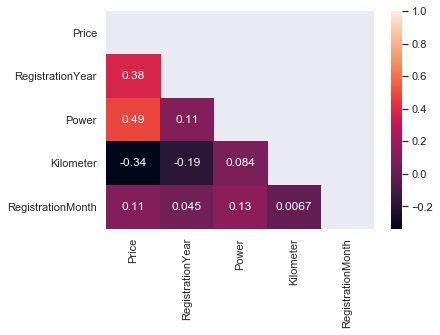

In [12]:
matrix = np.triu(data.corr())
sb.heatmap(data.corr(), annot=True, mask=matrix)

##### Видим, что мощность и год регистрации авто сильно влияют на стоимость, что достаточно логично.

Разобьем все на train, valid и test в соотношении 60/20/20

In [13]:
features = data.drop('Price', axis=1)
target = data['Price']

In [14]:
features_train, features_valid, target_train, target_valid = (
    train_test_split(features, target, test_size=0.4, random_state=12345)
)
features_valid, features_test, target_valid, target_test = (
    train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345)
)

# 2. Обучение моделей

Выберем следующую стартегию:
1. Напишем функцию, которая будет принимать на вход модель с наилучшими показателями, делать предсказание на валидации. RMSE и время обучения и предсказания добавим в список result
2. Дополнительно создадим список с моделями, чтобы выбрать лучшую и проверить на тесте.
3. Сравним модели XGBoost,LightGBM, CatBoost
4. Сравним показатели по качеству и скорости обучения и выберем лучшую модель

In [15]:
# функция из п.1
def model_params(model, x_train, y_train, x_test, y_test):
    start = time.time()
    model.fit(x_train, y_train)
    fit_time = time.time() - start
    
    start = time.time()
    predicted = model.predict(x_test)
    predict_time = time.time() - start
    rmse = mean_squared_error(y_test, predicted)**0.5
    
    return fit_time, predict_time, rmse

Создадим список с моделями

In [16]:
models = []

### 1. Обучим XGBoost
Для этого напишем пайплайн и сделаем ohe.
Будем делать поиск по сетке количества деревьев и параметра eta, отвечающего за веса предсказаний моделей, используя GridSearchCV.  
Так же будем проверять качество на 5 фолдах с помощую KFold

In [17]:
pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('xgbr', XGBRegressor(verbosity=0))
])

params = [
    {
        'xgbr__eta': np.arange(0.1,0.6,0.2),
        'xgbr__max_depth': np.arange(5,26,10)
    } 
]

cv = KFold(n_splits=5, shuffle=True)

grid_xgbr = GridSearchCV(pipe,
                    param_grid=params,
                    cv=cv,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=False)

In [18]:
%%time
grid_xgbr.fit(features_train, target_train)

Wall time: 5min 15s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ohe',
                                        OneHotEncoder(categories='auto',
                                                      drop=None,
                                                      dtype=<class 'numpy.float64'>,
                                                      handle_unknown='ignore',
                                                      sparse=True)),
                                       ('xgbr',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=Non...
                        

##### Добавим результаты в наш список models

In [19]:
models.append(grid_xgbr.best_estimator_)
grid_xgbr.best_params_

{'xgbr__eta': 0.30000000000000004, 'xgbr__max_depth': 15}

##### Добавим результаты в наш список result

In [20]:
result = []
result.append(model_params(grid_xgbr.best_estimator_, features_train, target_train, features_valid, target_valid))

In [21]:
result[0]

(8.79400634765625, 0.6249527931213379, 1806.6248970745498)

#### 2. Обучим LightGBM 
Сделаем всё тоже самое, что и для XGBoost

In [22]:
pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ('lgbmr', LGBMRegressor(verbosity=0))
])

params = [
    {
        'lgbmr__num_leaves ': np.arange(21,42,10),
        'lgbmr__max_depth': np.arange(15,36,10),
        'lgbmr__n_estimators': np.arange(50,151,50),
    } 
]

cv = KFold(n_splits=5, shuffle=True)

grid_lgbm = GridSearchCV(pipe,
                    param_grid=params,
                    cv=cv,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    verbose=False)

In [23]:
%%time
grid_lgbm.fit(features_valid, target_valid)

[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 21
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 21
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Wall time: 42.6 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ohe',
                                        OneHotEncoder(categories='auto',
                                                      drop=None,
                                                      dtype=<class 'numpy.float64'>,
                                                      handle_unknown='ignore',
                                                      sparse=True)),
                                       ('lgbmr',
                                        LGBMRegressor(boosting_type='gbdt',
                                                      class_weight=None,
                                                      colsample_bytree=1.0,
                                                      importance_type='split',
                                                      learning...
                    

In [24]:
models.append(grid_lgbm.best_estimator_)
grid_lgbm.best_params_

{'lgbmr__max_depth': 35, 'lgbmr__n_estimators': 150, 'lgbmr__num_leaves ': 21}

In [25]:
result.append(model_params(grid_lgbm.best_estimator_, features_train, target_train, features_valid, target_valid))

[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 21
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 21
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011678 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [26]:
result[1]

(1.622556209564209, 0.4442131519317627, 1967.580589940998)

#### 3. Обучим CatBoost
Сделаем всё тоже самое, что и для XGBoost. Для CatBoost'a можно не делать ohe, при этом указав категориальные переменные, так и сделаем.

In [27]:
cat_col = ['VehicleType', 'Gearbox', 'Model', 'FuelType',
           'Brand', 'RegistrationMonth', 'NotRepaired']

In [28]:
cbr = CatBoostRegressor(random_seed=12345,
                        loss_function='RMSE',
                        silent=True,
                        cat_features=cat_col)

params = {
    'iterations': [40, 60],
    'depth': [6, 8, 10],
}

grid_cbr = GridSearchCV(cbr,
                    params,
                    cv=cv,
                    scoring='neg_mean_squared_error',
                    verbose=False)

In [29]:
%%time
grid_cbr.fit(features_valid, target_valid)

Wall time: 1min 7s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000024EE4C180C8>,
             iid='deprecated', n_jobs=None,
             param_grid={'depth': [6, 8, 10], 'iterations': [40, 60]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=False)

In [30]:
models.append(grid_cbr.best_estimator_)
grid_cbr.best_params_

{'depth': 10, 'iterations': 60}

In [31]:
result.append(model_params(grid_cbr.best_estimator_, features_train, target_train, features_valid, target_valid))

In [32]:
result[2]

(6.594092607498169, 0.17696547508239746, 1780.0734220909937)

## 3.Анализ моделей
Создадим таблицу по данным о моделях

In [33]:
pd.DataFrame(result, columns = ['trainig_time', 'predic_time', 'RME'],
             index=['XGBoost','LightGBM','CatBoost'])

,trainig_time,predic_time,RME
XGBoost,8.794006,0.624953,1806.624897
LightGBM,1.622556,0.444213,1967.580590
CatBoost,6.594093,0.176965,1780.073422


Судя по данным, CatBoost предсказывает быстрее всего и даёт более точно предсказание.  
Выберем его в качестве модели и протестируем на тестовой выборке.

## Тестирование модели

In [34]:
model = models[2]
model.fit(features_train, target_train)

In [35]:
mean_squared_error(target_test, model.predict(features_test))**0.5

1762.6067198288608